In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# Use evaluation metrics are accuracy_score, precision, recall, F1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
# Remove the UndefinedMetricWarning warning
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

DATA_FOLDER = 'data'

NAME = 'name'
GENRES = 'genres'
DESCRIPTION = 'description_raw'
DESCRIPTION_CLEANED = 'description_cleaned'
DESCRIPTION_LEMMATIZED = 'description_lemmatized'
DESCRIPTION_STEMMED = 'description_stemmed'
DESCRIPTION_NO_LEMMA_STEM = 'description_no_lemma_stem'

TEST_SIZE = 0.2
RANDOM_STATE = 42

In [3]:
# Load the data
df = pd.read_csv(os.path.join(DATA_FOLDER, 'steam_games_reduced_2.csv'))

In [4]:
# Split the data into features and target
X1_raw = df[DESCRIPTION]
X1_cleaned = df[DESCRIPTION_CLEANED]
X1_lemma = df[DESCRIPTION_LEMMATIZED]
X1_stem = df[DESCRIPTION_STEMMED]
X1_no_lemma_stem = df[DESCRIPTION_NO_LEMMA_STEM]
y = df[GENRES]

def split_data(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    # Print the shape of the training and testing sets
    print(f"Training set shape X: {X_train.shape}, y: {y_train.shape}")
    print(f"Testing set shape X: {X_test.shape}, y: {y_test.shape}")
    return X_train, X_test, y_train, y_test

# Split the data into training and testing sets
X1_raw_train, X1_raw_test, y_train, y_test = split_data(X1_raw, y)
X1_cleaned_train, X1_cleaned_test, _, _ = split_data(X1_cleaned, y)
X1_lemma_train, X1_lemma_test, _, _ = split_data(X1_lemma, y)
X1_stem_train, X1_stem_test, _, _ = split_data(X1_stem, y)
X1_no_lemma_stem_train, X1_no_lemma_stem_test, _, _ = split_data(X1_no_lemma_stem, y)

Training set shape X: (2391,), y: (2391,)
Testing set shape X: (598,), y: (598,)
Training set shape X: (2391,), y: (2391,)
Testing set shape X: (598,), y: (598,)
Training set shape X: (2391,), y: (2391,)
Testing set shape X: (598,), y: (598,)
Training set shape X: (2391,), y: (2391,)
Testing set shape X: (598,), y: (598,)
Training set shape X: (2391,), y: (2391,)
Testing set shape X: (598,), y: (598,)


In [5]:
def fit_and_transform_vectorizer(vectorizer, X_train, X_test):
    # Fit and transform the vectorizer on the training data
    X_train_vectorized = vectorizer.fit_transform(X_train)
    # Transform the testing data
    X_test_vectorized = vectorizer.transform(X_test)
    return (X_train_vectorized, X_test_vectorized)

# Define the tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1))
tfidf_vectorizer_bigram = TfidfVectorizer(ngram_range=(1,2))

tfidf_vectors = {
    'Raw': fit_and_transform_vectorizer(tfidf_vectorizer, X1_raw_train, X1_raw_test),
    'Cleaned': fit_and_transform_vectorizer(tfidf_vectorizer, X1_cleaned_train, X1_cleaned_test),
    'Lemmatized': fit_and_transform_vectorizer(tfidf_vectorizer, X1_lemma_train, X1_lemma_test),
    'Stemmed': fit_and_transform_vectorizer(tfidf_vectorizer, X1_stem_train, X1_stem_test),
    'No lemma no stem': fit_and_transform_vectorizer(tfidf_vectorizer, X1_no_lemma_stem_train, X1_no_lemma_stem_test),
    'Raw w/ bigrams': fit_and_transform_vectorizer(tfidf_vectorizer_bigram, X1_raw_train, X1_raw_test),
    'Cleaned w/ bigrams': fit_and_transform_vectorizer(tfidf_vectorizer_bigram, X1_cleaned_train, X1_cleaned_test),
    'Lemmatized w/ bigrams': fit_and_transform_vectorizer(tfidf_vectorizer_bigram, X1_lemma_train, X1_lemma_test),
    'Stemmed w/ bigrams': fit_and_transform_vectorizer(tfidf_vectorizer_bigram, X1_stem_train, X1_stem_test),
    'No lemma no stem w/ bigrams': fit_and_transform_vectorizer(tfidf_vectorizer_bigram, X1_no_lemma_stem_train, X1_no_lemma_stem_test)
}

In [6]:
def train_and_predict(model, vectorizer_name: str, X_train, y_train, X_test, y_test):
    # Train the model
    trained_model = model.fit(X_train, y_train)
    
    # Predict the output
    y_pred = trained_model.predict(X_test)
    
    print(f"{model.__class__.__name__} with {vectorizer_name} : Accuracy {accuracy_score(y_test, y_pred):.4f}")
    
    # Return the trained model, vectorizer name and the predicted values
    return (trained_model, vectorizer_name, y_pred)

def build_predict_dict(model, tfidf_vectors):
    # Define the results dictionary
    results = {}
    full_name = ""
        
    for vectorizer_name, (X_train, X_test) in tfidf_vectors.items():
        full_name = "TfIdf / "+vectorizer_name
        results[(model, full_name)] = train_and_predict(model, full_name, X_train, y_train, X_test, y_test)
        
    return results

In [7]:
def evaluate_model(y_test, y_pred):
    # Calculate the evaluation metrics
    accuracy_value = accuracy_score(y_test, y_pred)
    precision_value = precision_score(y_test, y_pred, average='macro')
    recall_value = recall_score(y_test, y_pred, average='macro')
    f1_score_value = f1_score(y_test, y_pred, average='macro')
    
    return {
        'accuracy': accuracy_value,
        'precision': precision_value,
        'recall': recall_value,
        'f1_score': f1_score_value,
    }

# Evaluate the models
def evaluate_models(results, y_test):
    evaluation_results = {}
    
    # Print the model name
    print(f"Model : {list(results.keys())[0][0].__class__.__name__}")
    
    # Print the header
    print("="*80)
    print(f"{'Vectorizer/Data form':<38} {'Accuracy':<9} {'Precision':<9} {'Recall':<9} {'F1 Score':<9}")
    print("="*80)
    
    for (model, vectorizer_name), (trained_model, vectorizer_name, y_pred) in results.items():
        evaluation_metrics = evaluate_model(y_test, y_pred)
        evaluation_results[(model, vectorizer_name)] = evaluation_metrics
        
        # Print the evaluation results
        print(f"{vectorizer_name:<38} "
        f"{evaluation_metrics['accuracy']:<9.4f} "
        f"{evaluation_metrics['precision']:<9.4f} "
        f"{evaluation_metrics['recall']:<9.4f} "
        f"{evaluation_metrics['f1_score']:<9.4f}")
        
    return evaluation_results

In [8]:
# Train a multinomial naive bayes classifier
multinomial_nb = MultinomialNB()
multinomial_nb_results = build_predict_dict(multinomial_nb, tfidf_vectors)

MultinomialNB with TfIdf / Raw : Accuracy 0.6906
MultinomialNB with TfIdf / Cleaned : Accuracy 0.7174
MultinomialNB with TfIdf / Lemmatized : Accuracy 0.7040
MultinomialNB with TfIdf / Stemmed : Accuracy 0.7090
MultinomialNB with TfIdf / No lemma no stem : Accuracy 0.7057
MultinomialNB with TfIdf / Raw w/ bigrams : Accuracy 0.6722
MultinomialNB with TfIdf / Cleaned w/ bigrams : Accuracy 0.7057
MultinomialNB with TfIdf / Lemmatized w/ bigrams : Accuracy 0.6957
MultinomialNB with TfIdf / Stemmed w/ bigrams : Accuracy 0.7074
MultinomialNB with TfIdf / No lemma no stem w/ bigrams : Accuracy 0.7040


In [9]:
# Train a logistic regression model
logistic_regression = LogisticRegression(max_iter=1000, n_jobs=-1)
logistic_regression_results = build_predict_dict(logistic_regression, tfidf_vectors)

LogisticRegression with TfIdf / Raw : Accuracy 0.7525
LogisticRegression with TfIdf / Cleaned : Accuracy 0.7425
LogisticRegression with TfIdf / Lemmatized : Accuracy 0.7358
LogisticRegression with TfIdf / Stemmed : Accuracy 0.7341
LogisticRegression with TfIdf / No lemma no stem : Accuracy 0.7341
LogisticRegression with TfIdf / Raw w/ bigrams : Accuracy 0.7324
LogisticRegression with TfIdf / Cleaned w/ bigrams : Accuracy 0.7475
LogisticRegression with TfIdf / Lemmatized w/ bigrams : Accuracy 0.7425
LogisticRegression with TfIdf / Stemmed w/ bigrams : Accuracy 0.7408
LogisticRegression with TfIdf / No lemma no stem w/ bigrams : Accuracy 0.7375


In [10]:
# Train a random forest classifier
random_forest = RandomForestClassifier(n_jobs=-1)
random_forest_results = build_predict_dict(random_forest, tfidf_vectors)

RandomForestClassifier with TfIdf / Raw : Accuracy 0.6973
RandomForestClassifier with TfIdf / Cleaned : Accuracy 0.7191
RandomForestClassifier with TfIdf / Lemmatized : Accuracy 0.6890
RandomForestClassifier with TfIdf / Stemmed : Accuracy 0.6940
RandomForestClassifier with TfIdf / No lemma no stem : Accuracy 0.6940
RandomForestClassifier with TfIdf / Raw w/ bigrams : Accuracy 0.6973
RandomForestClassifier with TfIdf / Cleaned w/ bigrams : Accuracy 0.6839
RandomForestClassifier with TfIdf / Lemmatized w/ bigrams : Accuracy 0.6957
RandomForestClassifier with TfIdf / Stemmed w/ bigrams : Accuracy 0.6990
RandomForestClassifier with TfIdf / No lemma no stem w/ bigrams : Accuracy 0.6806


In [11]:
# Train a support vector classifier
svc = SVC()
svc_results = build_predict_dict(svc, tfidf_vectors)

SVC with TfIdf / Raw : Accuracy 0.7375
SVC with TfIdf / Cleaned : Accuracy 0.7324
SVC with TfIdf / Lemmatized : Accuracy 0.7258
SVC with TfIdf / Stemmed : Accuracy 0.7258
SVC with TfIdf / No lemma no stem : Accuracy 0.7324
SVC with TfIdf / Raw w/ bigrams : Accuracy 0.7007
SVC with TfIdf / Cleaned w/ bigrams : Accuracy 0.7308
SVC with TfIdf / Lemmatized w/ bigrams : Accuracy 0.7291
SVC with TfIdf / Stemmed w/ bigrams : Accuracy 0.7274
SVC with TfIdf / No lemma no stem w/ bigrams : Accuracy 0.7274


In [12]:
# Train a support vector classifier with a linear kernel
# svc_linear = SVC(kernel='linear')
# svc_linear_results = build_predict_dict(svc_linear, tfidf_vectors)
# svc_linear_evaluation_results = evaluate_models(svc_linear_results, y_test)

In [13]:
# Train a neural network classifier
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=200)
mlp_results = build_predict_dict(mlp, tfidf_vectors)
mlp_evaluation_results = evaluate_models(mlp_results, y_test)

MLPClassifier with TfIdf / Raw : Accuracy 0.7258
MLPClassifier with TfIdf / Cleaned : Accuracy 0.7224
MLPClassifier with TfIdf / Lemmatized : Accuracy 0.7023
MLPClassifier with TfIdf / Stemmed : Accuracy 0.7124
MLPClassifier with TfIdf / No lemma no stem : Accuracy 0.7157
MLPClassifier with TfIdf / Raw w/ bigrams : Accuracy 0.7224
MLPClassifier with TfIdf / Cleaned w/ bigrams : Accuracy 0.7007
MLPClassifier with TfIdf / Lemmatized w/ bigrams : Accuracy 0.7157
MLPClassifier with TfIdf / Stemmed w/ bigrams : Accuracy 0.7358
MLPClassifier with TfIdf / No lemma no stem w/ bigrams : Accuracy 0.6923
Model : MLPClassifier
Vectorizer/Data form                   Accuracy  Precision Recall    F1 Score 
TfIdf / Raw                            0.7258    0.7248    0.7291    0.7245   
TfIdf / Cleaned                        0.7224    0.7203    0.7269    0.7218   
TfIdf / Lemmatized                     0.7023    0.6990    0.7045    0.6994   
TfIdf / Stemmed                        0.7124    0.7112    0.

In [14]:
# Evaluate multinomialNB
multinomial_nb_evaluation_results = evaluate_models(multinomial_nb_results, y_test)

Model : MultinomialNB
Vectorizer/Data form                   Accuracy  Precision Recall    F1 Score 
TfIdf / Raw                            0.6906    0.7232    0.7006    0.6822   
TfIdf / Cleaned                        0.7174    0.7300    0.7249    0.7090   
TfIdf / Lemmatized                     0.7040    0.7222    0.7103    0.6960   
TfIdf / Stemmed                        0.7090    0.7234    0.7150    0.7033   
TfIdf / No lemma no stem               0.7057    0.7185    0.7126    0.6976   
TfIdf / Raw w/ bigrams                 0.6722    0.7229    0.6836    0.6658   
TfIdf / Cleaned w/ bigrams             0.7057    0.7269    0.7149    0.6970   
TfIdf / Lemmatized w/ bigrams          0.6957    0.7186    0.7030    0.6876   
TfIdf / Stemmed w/ bigrams             0.7074    0.7281    0.7152    0.7014   
TfIdf / No lemma no stem w/ bigrams    0.7040    0.7225    0.7115    0.6957   


In [15]:
# Evaluate logistic regression
logistic_regression_evaluation_results = evaluate_models(logistic_regression_results, y_test)

Model : LogisticRegression
Vectorizer/Data form                   Accuracy  Precision Recall    F1 Score 
TfIdf / Raw                            0.7525    0.7542    0.7526    0.7522   
TfIdf / Cleaned                        0.7425    0.7441    0.7432    0.7424   
TfIdf / Lemmatized                     0.7358    0.7353    0.7365    0.7343   
TfIdf / Stemmed                        0.7341    0.7367    0.7359    0.7344   
TfIdf / No lemma no stem               0.7341    0.7329    0.7350    0.7327   
TfIdf / Raw w/ bigrams                 0.7324    0.7353    0.7356    0.7326   
TfIdf / Cleaned w/ bigrams             0.7475    0.7472    0.7501    0.7454   
TfIdf / Lemmatized w/ bigrams          0.7425    0.7409    0.7443    0.7403   
TfIdf / Stemmed w/ bigrams             0.7408    0.7407    0.7419    0.7392   
TfIdf / No lemma no stem w/ bigrams    0.7375    0.7356    0.7385    0.7339   


In [16]:
# Evaluate random forest
random_forest_evaluation_results = evaluate_models(random_forest_results, y_test)

Model : RandomForestClassifier
Vectorizer/Data form                   Accuracy  Precision Recall    F1 Score 
TfIdf / Raw                            0.6973    0.7005    0.6994    0.6940   
TfIdf / Cleaned                        0.7191    0.7297    0.7216    0.7192   
TfIdf / Lemmatized                     0.6890    0.6949    0.6903    0.6833   
TfIdf / Stemmed                        0.6940    0.6932    0.6938    0.6900   
TfIdf / No lemma no stem               0.6940    0.7010    0.6937    0.6911   
TfIdf / Raw w/ bigrams                 0.6973    0.7023    0.7019    0.6930   
TfIdf / Cleaned w/ bigrams             0.6839    0.6935    0.6879    0.6774   
TfIdf / Lemmatized w/ bigrams          0.6957    0.7013    0.6993    0.6887   
TfIdf / Stemmed w/ bigrams             0.6990    0.7050    0.7016    0.6949   
TfIdf / No lemma no stem w/ bigrams    0.6806    0.6892    0.6827    0.6735   


In [17]:
# Evaluate support vector classifier
svc_evaluation_results = evaluate_models(svc_results, y_test)

Model : SVC
Vectorizer/Data form                   Accuracy  Precision Recall    F1 Score 
TfIdf / Raw                            0.7375    0.7499    0.7376    0.7402   
TfIdf / Cleaned                        0.7324    0.7446    0.7320    0.7345   
TfIdf / Lemmatized                     0.7258    0.7344    0.7249    0.7262   
TfIdf / Stemmed                        0.7258    0.7385    0.7243    0.7273   
TfIdf / No lemma no stem               0.7324    0.7433    0.7319    0.7338   
TfIdf / Raw w/ bigrams                 0.7007    0.7131    0.7019    0.7037   
TfIdf / Cleaned w/ bigrams             0.7308    0.7373    0.7333    0.7330   
TfIdf / Lemmatized w/ bigrams          0.7291    0.7340    0.7291    0.7290   
TfIdf / Stemmed w/ bigrams             0.7274    0.7332    0.7269    0.7276   
TfIdf / No lemma no stem w/ bigrams    0.7274    0.7308    0.7284    0.7277   


In [18]:
def plot_confusion_matrix(model_name, y_test, y_pred, vectorizer_name):
    clf_report = classification_report(y_test, y_pred, output_dict=True)
    
    # Print the classification report
    print(f"Classification Report for {model_name} with {vectorizer_name}")
    print("="*80)
    print(classification_report(y_test, y_pred))
    
    # Print the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
    # Get the labels and remove the 3 last labels but keep the order
    labels = list(clf_report.keys())[:-3]

    plt.figure(figsize=(10, 10))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.yticks(rotation=0)
    plt.ylabel('Actual')
    plt.title(f"{model_name}'s {vectorizer_name} Confusion Matrix")
    plt.show()

In [19]:
# From all the evaluation results, extract the best model
def get_best_model(evaluation_and_results):
    best_model = None
    best_f1_score = 0
    for model_name, results in evaluation_and_results.items():
        evaluation_results, model_results = results
        
        for (model, vectorizer_name), evaluation_metrics in evaluation_results.items():
            if evaluation_metrics['f1_score'] > best_f1_score:
                best_f1_score = evaluation_metrics['f1_score']
                key = (model, vectorizer_name)
                best_model = [model_name, key, evaluation_results[key], model_results[key]]
    return best_model


Classification Report for Logistic Regression with TfIdf / Raw
              precision    recall  f1-score   support

      Action       0.72      0.65      0.68        99
   Adventure       0.67      0.77      0.72        86
         RPG       0.65      0.67      0.66        70
      Racing       0.94      0.88      0.91        84
  Simulation       0.67      0.71      0.69        84
      Sports       0.86      0.88      0.87        88
    Strategy       0.78      0.71      0.74        87

    accuracy                           0.75       598
   macro avg       0.75      0.75      0.75       598
weighted avg       0.76      0.75      0.75       598



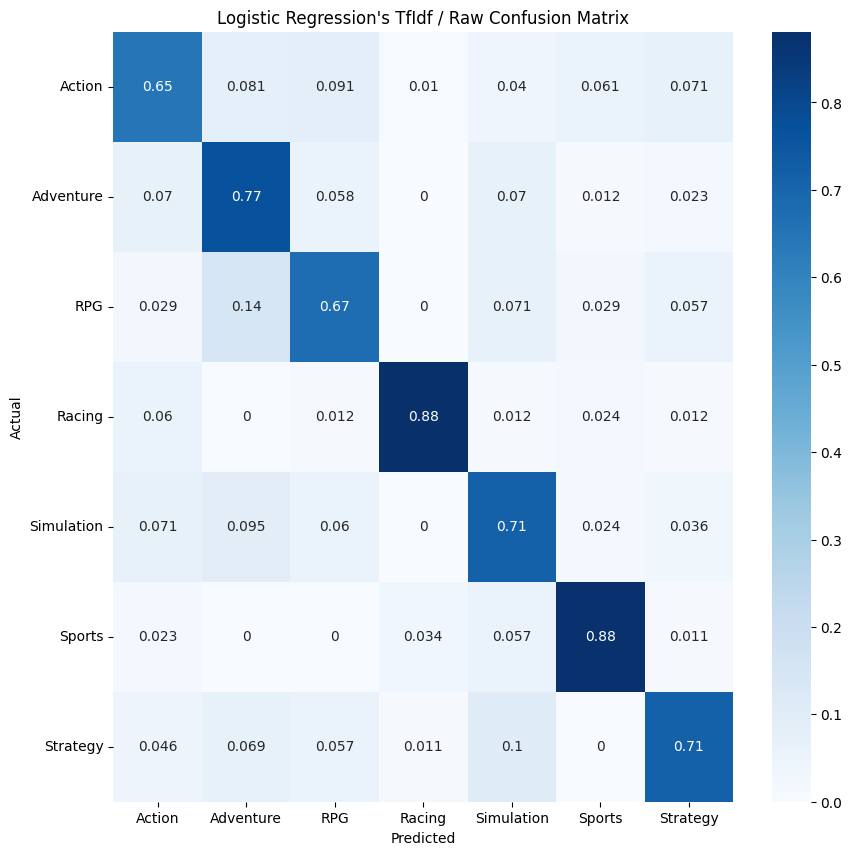

In [20]:
# Fusion of all the evaluation results
all_evaluation_results = {
    'MultinomialNB': (multinomial_nb_evaluation_results, multinomial_nb_results),
    'Logistic Regression': (logistic_regression_evaluation_results, logistic_regression_results),
    'Random Forest': (random_forest_evaluation_results, random_forest_results),
    'Support Vector Classifier': (svc_evaluation_results, svc_results)
}

# Get the best model
best_results = get_best_model(all_evaluation_results)

print()

# Plot the best model's confusion matrix
plot_confusion_matrix(best_results[0], y_test, best_results[3][2], best_results[1][1])